<a href="https://colab.research.google.com/github/IIVIIIII/2020_Weathering/blob/main/notebook/ccvi_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Filtering Data

In [1]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.1.2'
spark_version = 'spark-3.1.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64

# New Section

In [2]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("covid_regression").getOrCreate()

In [3]:
from pyspark import SparkFiles
url ="https://raw.githubusercontent.com/IIVIIIII/2020_Weathering/main/resources/ccvi_nonulls.csv"
spark.sparkContext.addFile(url)
ccvi = spark.read.csv(SparkFiles.get("ccvi_nonulls.csv"), sep=",", header=True)

# Show DataFrame
ccvi.show()


+----------+---------+----------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+-------------------+
|      FIPS|stateName|countyName|               ccvi|             theme1|             theme2|             theme3|            theme4|            theme5|            theme6|             theme7|
+----------+---------+----------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+-------------------+
|1001020100|  ALABAMA|   Autauga|        0.441972264|0.45833621799999996|         0.37747817|        0.170811065|       0.841616783|        0.96629414|       0.209805276|        0.287591301|
|1001020200|  ALABAMA|   Autauga| 0.7426192490000001|        0.562935368|        0.584587292|        0.683825769|       0.768946675|0.9823988140000001|       0.209805276|        0.427810423|
|1001020300|  ALABAMA|   Autauga|        0.77

In [4]:
url ="https://data.cdc.gov/api/views/n8mc-b4w4/rows.csv"
spark.sparkContext.addFile(url)
covid = spark.read.csv(SparkFiles.get("rows.csv"), sep=",", header=True)

# Show DataFrame
covid.show()

+----------+---------+---------------+--------------+----------------+--------------+------+-------+---------+-------------------------------+-------------------+-------------------+-----------+--------------------+--------------+-------+-------+--------+------------------------+
|case_month|res_state|state_fips_code|    res_county|county_fips_code|     age_group|   sex|   race|ethnicity|case_positive_specimen_interval|case_onset_interval|            process|exposure_yn|      current_status|symptom_status|hosp_yn| icu_yn|death_yn|underlying_conditions_yn|
+----------+---------+---------------+--------------+----------------+--------------+------+-------+---------+-------------------------------+-------------------+-------------------+-----------+--------------------+--------------+-------+-------+--------+------------------------+
|   2020-12|       AL|             01|     ST. CLAIR|           26147|            NA|    NA|     NA|       NA|                           null|               

In [118]:
covid_cases = covid.filter(covid["county_fips_code"] != 'NA')
covid_deaths = covid_cases.filter(covid_cases["death_yn"] == 'Yes')


In [6]:
covid_cases.show()


+----------+---------+---------------+--------------+----------------+--------------+------+-------+---------+-------------------------------+-------------------+-------------------+-----------+--------------------+--------------+-------+-------+--------+------------------------+
|case_month|res_state|state_fips_code|    res_county|county_fips_code|     age_group|   sex|   race|ethnicity|case_positive_specimen_interval|case_onset_interval|            process|exposure_yn|      current_status|symptom_status|hosp_yn| icu_yn|death_yn|underlying_conditions_yn|
+----------+---------+---------------+--------------+----------------+--------------+------+-------+---------+-------------------------------+-------------------+-------------------+-----------+--------------------+--------------+-------+-------+--------+------------------------+
|   2020-12|       AL|             01|     ST. CLAIR|           26147|            NA|    NA|     NA|       NA|                           null|               

In [36]:
import pandas as pd
from pyspark.sql.functions import pandas_udf

@pandas_udf('string')
def just_county(series: pd.Series) -> pd.Series:
  return series.apply(lambda x: x[:5])

counties = ccvi.select(just_county(ccvi.FIPS), ccvi.ccvi).withColumnRenamed('just_county(FIPS)','county_fips_code')
counties.show()


+----------------+-------------------+
|county_fips_code|               ccvi|
+----------------+-------------------+
|           10010|        0.441972264|
|           10010| 0.7426192490000001|
|           10010|        0.778071792|
|           10010|        0.362727033|
|           10010| 0.8165999359999999|
|           10010|        0.738005846|
|           10010|        0.777392943|
|           10010|         0.32720522|
|           10010|        0.712805309|
|           10010|        0.429475901|
|           10010|        0.603607598|
|           10010|        0.690292459|
|           10030|0.33472797600000004|
|           10030|         0.58888073|
|           10030|0.39719593799999997|
|           10030|        0.214890345|
|           10030| 0.7148972720000001|
|           10030|         0.88074424|
|           10030|        0.457447251|
|           10030|        0.497817985|
+----------------+-------------------+
only showing top 20 rows



In [57]:
# Import struct fields that we can use
from pyspark.sql.types import StructField, StringType, IntegerType, DoubleType, StructType

county_ccvi = counties.withColumn('ccvi', counties.ccvi.cast(DoubleType()))

county_ccvi = county_ccvi.groupby('county_fips_code').avg()

county_ccvi = county_ccvi.toPandas()

county_ccvi


,county_fips_code,avg(ccvi)
0,60070,0.536985
1,19095,0.210540
2,22121,0.800673
3,26005,0.380483
4,28117,0.551965
...,...,...
3168,29201,0.639436
3169,36075,0.488158
3170,39039,0.372042
3171,42015,0.332772


In [121]:
cases = covid_cases.groupBy('county_fips_code').count().toPandas()
deaths = covid_deaths.groupBy('county_fips_code').count().toPandas()

In [128]:
case_count = pd.merge(cases, county_ccvi, on='county_fips_code')
death_count = pd.merge(deaths, county_ccvi, on='county_fips_code')


In [124]:
import requests
import json

url = "https://api.census.gov/data/2019/acs/acs5?get=B01003_001E&for=county:*&in=state:*"
response = requests.get(url).json()

county_pop = pd.DataFrame(response)

county_pop




,0,1,2
0,B01003_001E,state,county
1,21565,17,051
2,29003,17,107
3,23994,17,165
4,701473,17,097
...,...,...,...
3216,14399,47,033
3217,7401,47,095
3218,461104,47,093
3219,197518,53,005


In [125]:
county_pop = county_pop.rename(columns={0: 'population', 1: 'state', 2: 'county_fips_code'})

county_pop = county_pop.loc[county_pop['state'] != 'state',:]

county_pop


,population,state,county_fips_code
1,21565,17,051
2,29003,17,107
3,23994,17,165
4,701473,17,097
5,14219,17,127
...,...,...,...
3216,14399,47,033
3217,7401,47,095
3218,461104,47,093
3219,197518,53,005


In [126]:
county_pop['county_fips_code'] = county_pop['state'] + county_pop['county_fips_code']

county_pop = county_pop.drop(columns=['state'])

county_pop


,population,county_fips_code
1,21565,17051
2,29003,17107
3,23994,17165
4,701473,17097
5,14219,17127
...,...,...
3216,14399,47033
3217,7401,47095
3218,461104,47093
3219,197518,53005


In [129]:
county_covid_cases = pd.merge(case_count, county_pop, on='county_fips_code')
county_covid_deaths = pd.merge(death_count, county_pop, on='county_fips_code')


,county_fips_code,count,avg(ccvi),population
0,36067,122,0.486908,462872
1,39103,183,0.258305,177980
2,26005,36,0.380483,116143
3,55089,19,0.092371,88597
4,51550,53,0.408755,239982
...,...,...,...,...
670,17195,109,0.446679,56016
671,26049,430,0.413558,407875
672,53063,375,0.260410,505505
673,39039,62,0.372042,38160


In [130]:
county_covid_cases = county_covid_cases.astype({'population': 'int64'})
county_covid_deaths = county_covid_deaths.astype({'population': 'int64'})

county_covid_cases['percent_infected'] = (county_covid_cases['count']/county_covid_cases['population'])*100
county_covid_deaths['percent_infected'] = (county_covid_deaths['count']/county_covid_deaths['population'])*100

county_covid_cases
county_covid_deaths


,county_fips_code,count,avg(ccvi),population,percent_infected
0,36067,122,0.486908,462872,0.026357
1,39103,183,0.258305,177980,0.102821
2,26005,36,0.380483,116143,0.030996
3,55089,19,0.092371,88597,0.021445
4,51550,53,0.408755,239982,0.022085
...,...,...,...,...,...
670,17195,109,0.446679,56016,0.194587
671,26049,430,0.413558,407875,0.105424
672,53063,375,0.260410,505505,0.074183
673,39039,62,0.372042,38160,0.162474


In [113]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

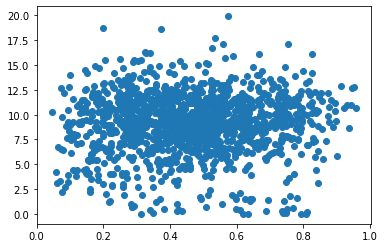

In [135]:
X = county_covid_cases['avg(ccvi)'].values.reshape(-1, 1)
y = county_covid_cases['percent_infected'].values.reshape(-1, 1)

import matplotlib.pyplot as plt
plt.scatter(X, y)

# import necessary dependencies
from sklearn.model_selection import train_test_split

# create split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


Min X Value: [[0.04515138]]
Max X Value: [[0.95856628]]
[[8.67431574]]
[[9.47874906]]


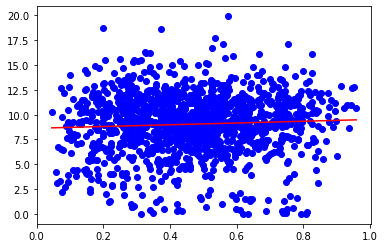

In [134]:
import numpy as np

model.fit(X_train, y_train)

print(f'score: {model.score(X_test, y_test)}')

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])
print(f"Min X Value: {x_min}")
print(f"Max X Value: {x_max}")
### BEGIN SOLUTION
y_min = model.predict(x_min)
y_max = model.predict(x_max)
print(y_min)
print(y_max)
### END SOLUTION
### BEGIN SOLUTION
plt.scatter(X, y, c='blue')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')
### END SOLUTION

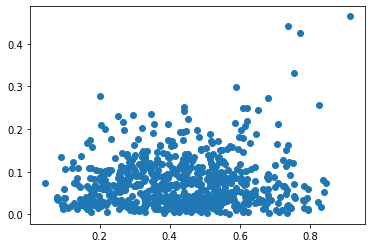

In [136]:
X = county_covid_deaths['avg(ccvi)'].values.reshape(-1, 1)
y = county_covid_deaths ['percent_infected'].values.reshape(-1, 1)

import matplotlib.pyplot as plt
plt.scatter(X, y)

# import necessary dependencies
from sklearn.model_selection import train_test_split

# create split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


score: 0.007178505185345574
Min X Value: [[0.04515138]]
Max X Value: [[0.91306172]]
[[0.06543872]]
[[0.08544007]]


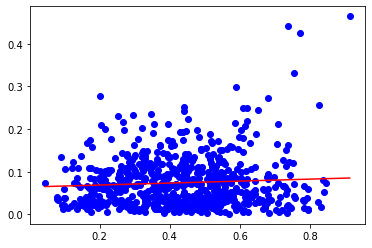

In [137]:
import numpy as np

model.fit(X_train, y_train)

print(f'score: {model.score(X_test, y_test)}')

x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])
print(f"Min X Value: {x_min}")
print(f"Max X Value: {x_max}")
### BEGIN SOLUTION
y_min = model.predict(x_min)
y_max = model.predict(x_max)
print(y_min)
print(y_max)
### END SOLUTION
### BEGIN SOLUTION
plt.scatter(X, y, c='blue')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')
### END SOLUTION

In [138]:
### BEGIN SOLUTION
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)
### END SOLUTION

Weight coefficients:  [[0.02304541]]
y-axis intercept:  [0.06439818]


In [ ]:
# county_ccvi = ccvi.join(counties, ['FIPS'])
# county_ccvi = county_ccvi.withColumnRenamed('just_county(FIPS)','county_fips_code')
# county_ccvi = meow

# county_ccvi.show()


NameError: ignored

In [ ]:
# Order a DataFrame by ascending values
df.orderBy(df["points"].asc()).show(5)

+-------+--------------------+--------------------+------+-----+--------+------------------+--------------+-------+------------+
|country|         description|         designation|points|price|province|          region_1|      region_2|variety|      winery|
+-------+--------------------+--------------------+------+-----+--------+------------------+--------------+-------+------------+
|     US|The strong aroma ...|                null|  null| null|    null|              null|          null|   null|        null|
|  Italy|This offers gener...|                null|  null| null|    null|              null|          null|   null|        null|
|     US|This shows a deft...|                null|  null| null|    null|              null|          null|   null|        null|
|  Italy|"This nicely stru...| bitter almond an...|  null|   88|      24|Northeastern Italy|Venezia Giulia|   null|Pinot Grigio|
|     US|               Ripe |                null|  null| null|    null|              null|     

In [ ]:
# Order a DataFrame by descending values
df.orderBy(df["points"].desc()).show(5)

+-------+--------------------+--------------------+------+-----+----------+-----------+--------+--------------------+--------------------+
|country|         description|         designation|points|price|  province|   region_1|region_2|             variety|              winery|
+-------+--------------------+--------------------+------+-----+----------+-----------+--------+--------------------+--------------------+
|     US|This is an absolu...|           IX Estate|    99|  290|California|Napa Valley|    Napa|           Red Blend|              Colgin|
| France|98-100 Barrel sam...|       Barrel sample|    99| null|  Bordeaux|   Pauillac|    null|Bordeaux-style Re...|Ch̢teau Pontet-Canet|
|     US|There are incredi...|Elevation 1147 Es...|    99|  150|California|Napa Valley|    Napa|  Cabernet Sauvignon|        David Arthur|
| France|A magnificent Cha...|Dom P̩rignon Oeno...|    99|  385| Champagne|  Champagne|    null|     Champagne Blend|     Mo��t & Chandon|
|  Italy|Even better than .

In [ ]:
# Import average function
from pyspark.sql.functions import avg
df.select(avg("points")).show()

+-----------------+
|      avg(points)|
+-----------------+
|87.88834105383143|
+-----------------+



In [ ]:
# Using filter
df.filter("price<20").show()

+---------+--------------------+--------------------+------+-----+----------------+--------------------+--------------------+--------------------+--------------------+
|  country|         description|         designation|points|price|        province|            region_1|            region_2|             variety|              winery|
+---------+--------------------+--------------------+------+-----+----------------+--------------------+--------------------+--------------------+--------------------+
| Bulgaria|This Bulgarian Ma...|             Bergul̩|    90|   15|        Bulgaria|                null|                null|              Mavrud|        Villa Melnik|
|    Spain|Earthy plum and c...|              Amandi|    90|   17|         Galicia|       Ribeira Sacra|                null|             Menc�_a|      Don Bernardino|
|       US|There's a lot to ...|                null|    90|   18|      California|Russian River Valley|              Sonoma|          Chardonnay|            De

In [ ]:
# Filter by price on certain columns
df.filter("price<20").select(['points','country', 'winery','price']).show()

+------+---------+--------------------+-----+
|points|  country|              winery|price|
+------+---------+--------------------+-----+
|    90| Bulgaria|        Villa Melnik|   15|
|    90|    Spain|      Don Bernardino|   17|
|    90|       US|            De Loach|   18|
|    91|       US|   Trinity Vineyards|   19|
|    91| Portugal|Adega Cooperativa...|   15|
|    86|       US|      Belle Ambiance|   10|
|    86| Portugal| Adega de Cantanhede|   12|
|    86|       US|            Parducci|   13|
|    86| Portugal|    Quinta do Portal|   10|
|    86|   France|               Rigal|   14|
|    86|       US|     The Naked Grape|   18|
|    86|   France|   Georges Vigouroux|   15|
|    86|   France|   Georges Vigouroux|   10|
|    86|       US| Martinez & Martinez|   17|
|    86|       US|           Ironstone|   12|
|    86|       US|       Leaping Horse|   10|
|    86|       US|        Kitchen Sink|   13|
|    86| Portugal|  Wines & Winemakers|   12|
|    86|Argentina|              Zo

### Using Python Comparison Operators

In [ ]:
# Same results only this time using python
df.filter(df["price"] < 200).show()

+-------+--------------------+--------------------+------+-----+------------------+------------------+-----------------+------------------+--------------------+
|country|         description|         designation|points|price|          province|          region_1|         region_2|           variety|              winery|
+-------+--------------------+--------------------+------+-----+------------------+------------------+-----------------+------------------+--------------------+
|  Spain|Ripe aromas of fi...|Carodorum Selecci...|    96|  110|    Northern Spain|              Toro|             null|     Tinta de Toro|Bodega Carmen Rod...|
|     US|Mac Watson honors...|Special Selected ...|    96|   90|        California|    Knights Valley|           Sonoma|   Sauvignon Blanc|            Macauley|
|     US|This spent 20 mon...|             Reserve|    96|   65|            Oregon| Willamette Valley|Willamette Valley|        Pinot Noir|               Ponzi|
| France|This is the top w...|    

In [ ]:
df.filter( (df["price"] < 200) | (df['points'] > 80) ).show()

+-------+--------------------+--------------------+------+-----+------------------+--------------------+-----------------+------------------+--------------------+
|country|         description|         designation|points|price|          province|            region_1|         region_2|           variety|              winery|
+-------+--------------------+--------------------+------+-----+------------------+--------------------+-----------------+------------------+--------------------+
|     US|This tremendous 1...|   Martha's Vineyard|    96|  235|        California|         Napa Valley|             Napa|Cabernet Sauvignon|               Heitz|
|  Spain|Ripe aromas of fi...|Carodorum Selecci...|    96|  110|    Northern Spain|                Toro|             null|     Tinta de Toro|Bodega Carmen Rod...|
|     US|Mac Watson honors...|Special Selected ...|    96|   90|        California|      Knights Valley|           Sonoma|   Sauvignon Blanc|            Macauley|
|     US|This spent 20

In [ ]:
df.filter(df["country"] == "US").show()

+-------+--------------------+--------------------+------+-----+----------+--------------------+-----------------+------------------+--------------------+
|country|         description|         designation|points|price|  province|            region_1|         region_2|           variety|              winery|
+-------+--------------------+--------------------+------+-----+----------+--------------------+-----------------+------------------+--------------------+
|     US|This tremendous 1...|   Martha's Vineyard|    96|  235|California|         Napa Valley|             Napa|Cabernet Sauvignon|               Heitz|
|     US|Mac Watson honors...|Special Selected ...|    96|   90|California|      Knights Valley|           Sonoma|   Sauvignon Blanc|            Macauley|
|     US|This spent 20 mon...|             Reserve|    96|   65|    Oregon|   Willamette Valley|Willamette Valley|        Pinot Noir|               Ponzi|
|     US|This re-named vin...|              Silice|    95|   65|    Or